In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cartesian_stiffness import *

In [2]:
robot = load_robot()
viz   = create_visualizer(robot)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
#robot.display(np.array([0.2, 0.3]))
#viz.viewer.jupyter_cell()

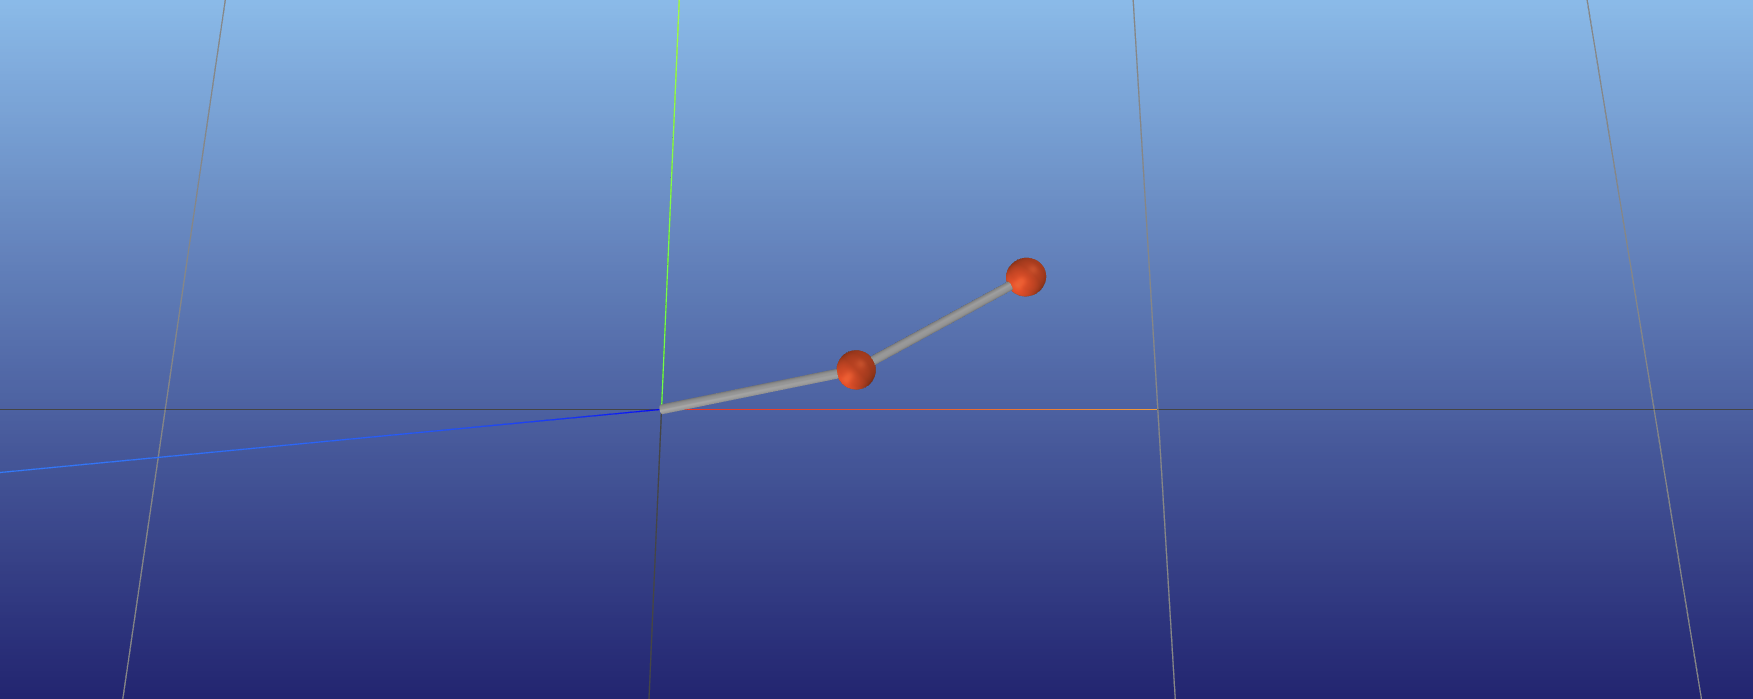

### Calculate $J = \frac{∂ fk(q)}{∂q}$ using CasADi

In [4]:
EE_FRAME = "m2_frame"

# q: 2x1 -> ΕΕ xyz: 1x3 
fk = symbolic_fk(robot, [EE_FRAME])

# q: 2x1 -> θxyz / θq_i: 3x2
q_sym = ca.SX.sym("q", robot.nq, 1)
jac = ca.Function("J", [q_sym], [ca.jacobian(fk(q_sym), q_sym)])

Make sure we didn't mess things up by calculating the Jacobian ourselves:

In [5]:
for _ in range(200):
    q_sample = np.random.uniform(-np.pi, np.pi, (2, 1))

    # Validate using Pinocchio:
    J_pin =  pin.computeFrameJacobian(
        robot.model, robot.data, q_sample,
        robot.model.getFrameId(EE_FRAME),
        pin.LOCAL_WORLD_ALIGNED
    )[:3, :]

    assert (np.max(np.abs(jac(q_sample) - J_pin)) <= 1e-4)

- **Dynamics:** $\frac{dx}{dt} = f(x, u)$

- **State:** $x = [q1, q2, v1, v2]^{T}$

- **Input:** $u = [u1, u2]^{T}$

In [6]:
# State x = vstack(q, q_dot): 4x1
# Input u: 2x1
def dynamics(x, u):
    q, q_dot = x[:2], x[2:]

    return np.vstack([
        q_dot,
        pin.aba(robot.model, robot.data, q, q_dot, u).reshape(-1, 1)
    ])

#### Inverse Kinematics implementations:
1. Euler steps along a "correction" EE velocity (*differential IK*)
1. Newton iterations on $EE_{pos}(q) - EE_{pos, desired} = 0$, with linesearch

In [7]:
def diff_ik_velocity(q0, p_ee_d):
    q, h = np.copy(q0), 1e-1
    iterations = 0

    while np.max(np.abs(p_ee_d - (p_ee := fk(q)))) > 1e-4:
        v_corr = (p_ee_d - p_ee)
        q_d_corr = ca.pinv(jac(q)) @ v_corr.T

        # Euler step on the error correcting EE velocity:
        q += h * np.array(q_d_corr)

        iterations += 1

    #print(f"Performed diff IK in {iterations} iterations.")
    return q

def ik_newton(q0, p_ee_d):
    q_k = np.copy(q0)
    err = lambda q: (fk(q) - p_ee_d).T
    p = lambda q: 0.5 * (e := err(q)).T @ e     # 1/2 norm(e(q))^2 merit

    iterations = 0

    while np.max(np.abs(p_ee_d - fk(q_k))) > 1e-4:
        e_k, p_k, J_k = err(q_k), p(q_k), jac(q_k)

        # Zero out linearization:
        Δq = -ca.pinv(J_k) @ e_k       

        # Line search using Armijo rule:
        α = 1.
        while p(q_k + α * Δq) > p_k + 1e-4 * (e_k.T @ J_k) @ (α * Δq):
            α *= 0.5
            print(f"Linesearch backtracking (α={α})")


        q_k += α * Δq
        iterations += 1

    #print(f"Performed IK using Newton in {iterations} iterations.")
    return np.array(q_k)

#### Test to see whether we can move in a straight line:

In [8]:
def visualize_ee_trajectory(x_hist, cmap = "viridis"):
    xs, ys = zip(*[np.array(fk(x[:2]))[0, :2] for x in x_hist])
    c = [idx / len(xs) for idx in range(len(xs))]
    
    plt.scatter(xs, ys, s = 2, c = c, cmap = cmap)

    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Trajectory Progress", rotation=270, labelpad=20)
    plt.title("End effector (m2) trajectory")

In [9]:
solutions = []
q0 = np.random.uniform(-np.pi, np.pi, (2, 1))

for x in np.arange(0.0, 0.35, 1e-3):
    q_sol = ik_newton(q0, np.array([[x, 0.1, 0.0]]))
    solutions.append(np.copy(q_sol))
    
    q0 = q_sol

(-0.1, 0.3)

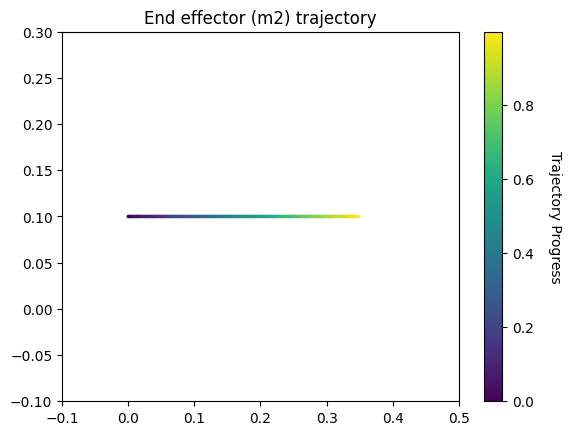

In [10]:
visualize_ee_trajectory(solutions)
plt.xlim(-0.1, 0.5)
plt.ylim(-0.1, 0.3)

### Simulation tools:

In [11]:
# Discretise using RK4:
def integrate_rk4(x, u, h):
    k1 = dynamics(x, u)             # Doing x_next = x + h * k1 is forward Euler
    k2 = dynamics(x + h/2 * k1, u)
    k3 = dynamics(x + h/2 * k2, u)
    k4 = dynamics(x + h   * k3, u)

    return x + h/6 * (k1 + 2*k2 + 2*k3 + k4)

Allow different simulation ($\frac{1}{h}$) and controller ($\frac{1}{ctrl\_period}$) frequencies while simulating:

In [12]:
u_hist = []

def simulate(q0, q_dot0, controller, h = 1e-3, t_max = 4, integrator = integrate_rk4, ctrl_period = None):
    t_now = 0.0
    x_hist = [np.vstack([q0, q_dot0])]
    
    
    while t_now < t_max:
        x = x_hist[-1]

        # We will zero order hold the torque command for `ctrl_period` time
        # (= h, if None). 
        u = controller(x[:2], x[2:])

        for _ in range(1 if ctrl_period is None else int(ctrl_period // h)):
            x_hist.append(integrator(x_hist[-1], u, h))
            t_now += h
            
    return x_hist

## 1) $J(q)$ transpose controller
-----

We calculate a spring force in the *end effector space*:

$f = Kp \cdot (x - x\_rest) + Kd \cdot (-v)$

and convert it to joint torques with: $τ = J^T \cdot f$

In [13]:
def J_T_spring_controller(q, v, x_d):
    Kp, Kd = 4, 0.2

    # End effector position / velocity errors:
    x_err = (x_d - fk(q)).T
    v_err = jac(q) @ (np.zeros((2, 1)) - v)

    # EE space spring force (the dynamics won't exactly be mass-spring-damper
    # because M_effective_EE changes with time, and there's Coriolis terms):
    ee_force = Kp * x_err + Kd * v_err
    τ = jac(q).T @ ee_force

    return np.array(τ)

#### Simulate for 4 seconds at 1kHz:

In [14]:
# Initial robot state (zero velocity):
x0 = np.array([[0.175, 0.1, 0.0]])
q0 = ik_newton(np.random.uniform(-np.pi, np.pi, (2, 1)), x0)

# EE spring rest position:
x_d = np.array([[0.3, 0.1, 0.0]])

x_hist = simulate(
    q0,
    np.zeros((2, 1)),
    lambda q, v: J_T_spring_controller(q, v, x_d),  # u = f(q, v) state feedback controller
    h = 1e-3,
    t_max = 4
)

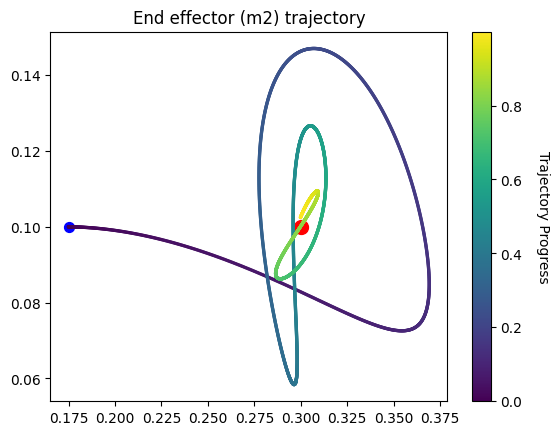

In [15]:
# Plot spring rest position as a red point:
plt.scatter([x_d[0, 0]], [x_d[0, 1]], s = 100, c = "red")

# Plot EE start position as a blue point:
plt.scatter([x0[0, 0]], [x0[0, 1]], s = 50, c = "blue")

visualize_ee_trajectory(x_hist)

### <ins>As we can see, the resulting end effector trajectory does not look like a Cartesian spring!</ins>
*Rest point of spring in **red**. Initial end effector position in **blue**.*

----

<ins>**To investigate why, we will write the end effector dynamics:**</ins>

- **Robot dynamics:**

> $M(q) \ddot{q} + C(q, \dot{q}) = τ$


- **Kinematics**

> $x_{ee} = fk(q)$


- **Velocity & acceleration kinematics:**

> $\dot{x_{ee}} = J(q) \dot{q}$ and $\ddot{x_{ee}} = J(q) \ddot{q} + \dot{J(q)} \dot{q}$

- **Apparent end effector force - joint torque relationship:**

> $τ = J(q)^{T}f$

----

$ => \tilde{M}(q) \ddot{x_{ee}} + \tilde{C}(q, \dot{q}) = f$ 

with:

- $\tilde{M}(q) = (J(q)M^{-1}J^T(q))^{-1}$ (*"effective" mass, seen from the pespective of the end effector*)
- $\tilde{C}(q, \dot{q}) = (J^T(q))^{-1}C(q, \dot{q}) - \tilde{M}(q) \dot{J(q)} \dot{q}$


#### We can see that plugging in $f = spring(x, \dot{x})$ would <ins>not</ins> result in spring dynamics for the end effector! This is due to:
- The fact that $\tilde{M}(q)$ heavily depends on state of robot
- The existence of $\tilde{C}(q, \dot{q})$ terms

#### Reducing the control frequency to 10Hz makes things worse:

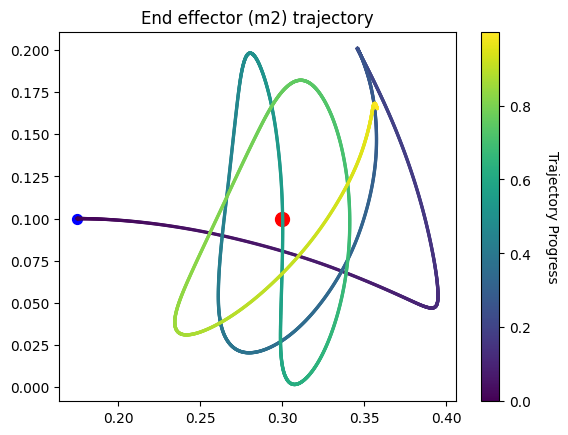

In [16]:
# subsampled control
x_hist_10hz = simulate(
    q0,
    np.zeros((2, 1)),
    lambda q, v: J_T_spring_controller(q, v, x_d),  # u = f(q, v) state feedback controller
    h = 1e-3,
    t_max = 4,
    ctrl_period = 1e-1
)

plt.scatter([x_d[0, 0]], [x_d[0, 1]], s = 100, c = "red")
plt.scatter([x0[0, 0]], [x0[0, 1]], s = 50, c = "blue")
visualize_ee_trajectory(x_hist_10hz)

To investigate whether $\tilde{C}(q, \dot{q})$ is the main reason behind the erratic trajectory, we try integrating **quasistatically**, zeroing out the velocity at each integration step to make $\tilde{C}$ vanish:

In [17]:
def integrate_no_vel(x, u, h):
    # Euler step forcing velocity to be zero always:
    
    x_quasi = np.vstack([x[:2, :], np.zeros((2, 1))])
    x_dot = dynamics(x_quasi, u)

    v_next = h * x_dot[2:, :]
    x_next = x[:2, :] + h * v_next

    return np.vstack([x_next, np.zeros((2, 1))])

We see a cleaner *(but a lot slower)* trajectory, but still the dependence of $\tilde{M}$ on $q$ makes the trajectory curved.
***We need to cancel both terms.***

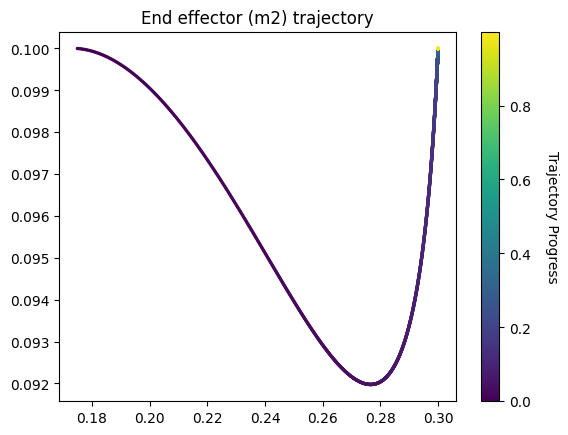

In [18]:
x_hist_quasi = simulate(
    q0,
    np.zeros((2, 1)),
    lambda q, v: J_T_spring_controller(q, v, x_d),  # u = f(q, v) state feedback controller
    h = 1e-2,
    t_max = 100,
    integrator = integrate_no_vel
)

visualize_ee_trajectory(x_hist_quasi)

## 2) Inverse dynamics controller
-----

To cancel out both Coriolis terms and the variable end effector mass, we first write the **desired** end effector dynamics:

> $M_{ee} \ddot{x} + K_p \cdot ({x - x_{rest}}) + K_d \cdot ({\dot{x}}) = 0$

For a given state $[q, \dot{q}]^T$, we can calculate $x = fk(q)$, $\dot{x} = J(q) \cdot \dot{q}$ and solve the above to get the desired ***end effector acceleration***: $\ddot{x}$.

We then find a ***desired joint space acceleration that produces $\ddot{x}$ at the current state*** by solving the acceleration kinematics:

> $\ddot{q} = (J(q))^{\dagger} (\ddot{x} - \dot{J(q)} \dot{q}) $

***We find joint torques to generate the desired joint acceleration $\ddot{q}$ using the RNEA ID algorithm.***

In [19]:
v_sym = ca.SX.sym("v", robot.nq, 1)
jac_dot = ca.Function("J_dot", [q_sym, v_sym], [ca.jtimes(jac(q_sym), q_sym, v_sym)[:2, :]])

def id_controller(q, v, x_d):
    M_desired = 0.3 * np.eye(2)    # Diagonal, make a bit fatter
    Kp        = 3. * np.eye(2)     # EE coords
    Kd        = 0.3 * np.eye(2)
    
    J = jac(q)
    
    # ee coords
    e_x  = (x_d - fk(q)).T[:2]
    e_xd = (jac(q) @ (np.zeros((2, 1)) - v))[:2]
    
    # springy dynamics (EE coords)
    x_dd_spring = (np.linalg.inv(M_desired) @ (Kp @ e_x + Kd @ e_xd))
                     
    # convert to q_dd
    J_dot_times_v = np.array(jac_dot(q0, v)) @ v
    q_dd = np.array(np.linalg.pinv(J[:2, :]) @ (x_dd_spring - J_dot_times_v))
    
    τ = pin.rnea(robot.model, robot.data, q, v, q_dd)
    return np.array(τ)

### We now get spring like movement in Cartesian space!

(0.05, 0.15)

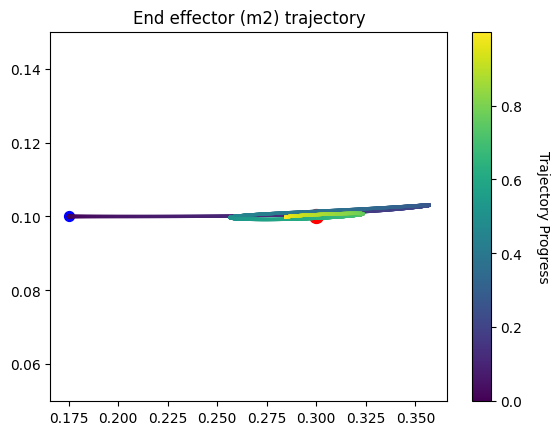

In [20]:
x_hist_id = simulate(
    q0,
    np.zeros((2, 1)),
    lambda q, v: id_controller(q, v, x_d),  # u = f(q, v) state feedback controller
    h = 1e-3,
    t_max = 4,
)

plt.scatter([x_d[0, 0]], [x_d[0, 1]], s = 100, c = "red")
plt.scatter([x0[0, 0]], [x0[0, 1]], s = 50, c = "blue")

visualize_ee_trajectory(x_hist_id)
plt.ylim(0.05, 0.15)

#### Visualise trajectory:

In [21]:
#viz.viewer.jupyter_cell()

In [22]:
skip = False

for x in x_hist_id:
    if not skip:
        robot.display(x[:2])
    
    skip = not skip

However, as we predicted, reducing the control frequency too low means that the torques generated are ***not accurate enough to produce the desired trajectory as the state of the system evolves.***

> Below is a simulation with the controller running at $~5.6$ Hz.

The trajectory is degraded.

(0.05, 0.15)

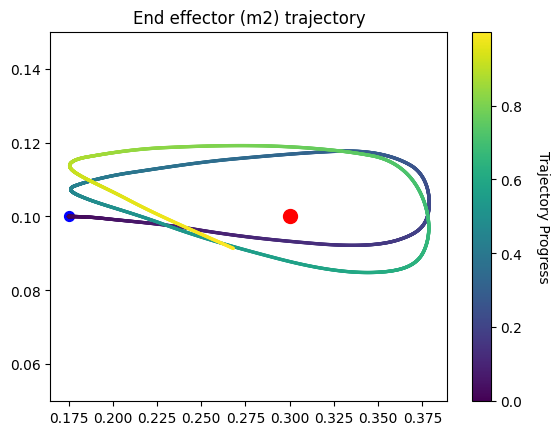

In [23]:
x_hist_id_low_freq = simulate(
    q0, np.zeros((2, 1)), lambda q, v: id_controller(q, v, x_d),
    h = 1e-3, t_max = 4, ctrl_period = 0.18
)

plt.scatter([x_d[0, 0]], [x_d[0, 1]], s = 100, c = "red")
plt.scatter([x0[0, 0]], [x0[0, 1]], s = 50, c = "blue")

visualize_ee_trajectory(x_hist_id_low_freq)
plt.ylim(0.05, 0.15)

----

### We will now linearise the controller at every evaluation.

This way, in-between evaluations we can apply the linear approximation to the full controller:
> $τ_{linear}(q, \dot{q}) = A \cdot [q, \dot{q}]^T +b$

instead of just zero-order-hold'ing a calculated torque. ***This should give us way better behaviour at low controller frequencies.***

In [24]:
cmodel = cpin.Model(robot.model)
cdata = cmodel.createData()

#### We write the ID controller symbolically using CasADi so that we can get its first order derivative:

In [25]:
def id_controller_symbolic(x):
    M_desired     = 0.3 * ca.SX.eye(2)
    Kp            = 3. * ca.SX.eye(2)
    Kd            = 0.3 * ca.SX.eye(2)
    x_ee_desired  = ca.SX([[0.3, 0.1]])
    
    q, v = x[:2], x[-2:]
    J = jac(q)[:2, :]
    
    x_ee, x_ee_d = fk(q)[:2], (jac(q) @ v)[:2].T
    
    x_ee_dd = ca.inv(M_desired) @ (Kp @ (x_ee_desired - x_ee).T + Kd @ (- x_ee_d).T)
    q_dd = ca.pinv(J) @ (x_ee_dd - jac_dot(q, v) @ v)
    
    τ = cpin.rnea(cmodel, cdata, q, v, q_dd)
    return τ

### Simulate at 1kHz, with controller being linearized at 5.6Hz (as above):

(0.0, 0.2)

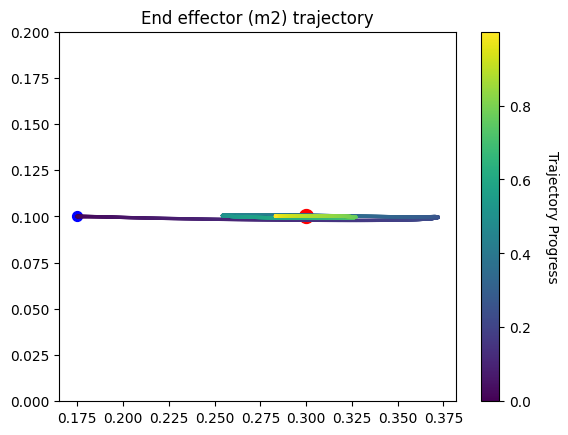

In [26]:
def simulate_with_linearization(
    q0, q_dot0, sym_ctrl, h = 1e-3, t_max = 4,
    integrator = integrate_rk4, recalculation_period = 0.1
):
    ctrl_hist = []
    
    x_sym = ca.SX.sym("x", 4, 1)
    τ = ca.Function("tau", [x_sym], [sym_ctrl(x_sym)])
    δτδx = ca.Function("del_tau_del_x", [x_sym], [ca.jacobian(τ(x_sym), x_sym)])
    
    t_now, t_lin, x_lin = 0.0, None, None
    x_hist = [np.vstack([q0, q_dot0])]
   
    while t_now < t_max:
        x = x_hist[-1]
        
        if t_lin is None or t_now - t_lin >= recalculation_period:
            A = δτδx(x)
            b = τ(x)
            x_lin = np.copy(x)
            t_lin = t_now
            
            ctrl_hist.append((np.copy(A), np.copy(b)))
                             
        τ_lin = np.array(A @ (x - x_lin) + b)
        x_hist.append(integrator(x, τ_lin, h))
        t_now += h
        
    return x_hist, ctrl_hist

x_hist_lin, controllers = simulate_with_linearization(
    q0,
    np.zeros((2, 1)),
    id_controller_symbolic,
    recalculation_period = 0.18
)

plt.scatter([x_d[0, 0]], [x_d[0, 1]], s = 100, c = "red")
plt.scatter([x0[0, 0]], [x0[0, 1]], s = 50, c = "blue")

visualize_ee_trajectory(x_hist_lin)
plt.ylim(0, 0.2)